# **Import Libraries**



In [40]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tqdm import tqdm

# **Load MovieLens 100k Dataset**

In [41]:
url = "https://files.grouplens.org/datasets/movielens/ml-100k/u.data"
columns = ["user_id", "item_id", "rating", "timestamp"]
df = pd.read_csv(url, sep="\t", names=columns)
print("Original Dataset Sample:")
df.head()

Original Dataset Sample:


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# **Convert explicit ratings to implicit feedback**

In [42]:
# We consider ratings >= 4 as positive interactions (implicit feedback)
df = df[df['rating'] >= 4]

# Encode users and items to 0-based indices
user_ids = df["user_id"].unique().tolist()
item_ids = df["item_id"].unique().tolist()

user2user_encoded = {x: i for i, x in enumerate(user_ids)}
item2item_encoded = {x: i for i, x in enumerate(item_ids)}

df["user"] = df["user_id"].map(user2user_encoded)
df["item"] = df["item_id"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item2item_encoded)

print(f"Total users: {num_users}, Total items: {num_items}")
print(f"Data sample after implicit feedback conversion:")
df.head()

Total users: 942, Total items: 1447
Data sample after implicit feedback conversion:


<ipython-input-42-a9d095a843fe>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["user"] = df["user_id"].map(user2user_encoded)
<ipython-input-42-a9d095a843fe>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["item"] = df["item_id"].map(item2item_encoded)


,user_id,item_id,rating,timestamp,user,item
5,298,474,4,884182806,0,0
7,253,465,5,891628467,1,1
11,286,1014,5,879781125,2,2
12,200,222,5,876042340,3,3
16,122,387,5,879270459,4,4


# **Create user-item interaction dictionary**

In [43]:
user_pos_items = df.groupby('user')['item'].apply(set).to_dict()
all_items = set(range(num_items))

# **Train/Test Split with leave-one-out strategy**

train_data, test_data = [], []

for user in user_pos_items:
    pos_items = list(user_pos_items[user])
    test_item = random.choice(pos_items)  # one item for test
    test_data.append((user, test_item, 1))
    for item in pos_items:
        if item != test_item:
            train_data.append((user, item, 1))

# **Add negative samples to training data**

In [44]:
# For each positive in train, add one negative sampled randomly from non-interacted items
for user in user_pos_items:
    pos_items = user_pos_items[user]
    neg_candidates = list(all_items - pos_items)
    neg_samples = random.sample(neg_candidates, len(pos_items))
    for item in neg_samples:
        train_data.append((user, item, 0))

random.shuffle(train_data)

train_df = pd.DataFrame(train_data, columns=["user", "item", "label"])
test_df = pd.DataFrame(test_data, columns=["user", "item", "label"])

print(f"Train dataset size: {len(train_df)}")
print(f"Test dataset size: {len(test_df)}")

Train dataset size: 109808
Test dataset size: 942


# **Define Matrix Factorization Model (dot product of embeddings)**

In [45]:
embedding_size = 50

user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

user_embedding = Embedding(num_users, embedding_size, name="user_embedding")(user_input)
item_embedding = Embedding(num_items, embedding_size, name="item_embedding")(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

dot_product = Dot(axes=1)([user_vec, item_vec])

model_mf = Model([user_input, item_input], dot_product)
model_mf.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
print("Matrix Factorization Model Summary:")
model_mf.summary()

Matrix Factorization Model Summary:


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,100 │ input_layer_6[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │     72,350 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_7 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ flatten_6[0][0],  │
│                     │                   │            │ flatten_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 119,450 (466.60 KB)

 Trainable params: 119,450 (466.60 KB)

 Non-trainable params: 0 (0.00 B)

# **Train Matrix Factorization Model**

In [46]:
history_mf = model_mf.fit(
    [train_df['user'], train_df['item']], train_df['label'],
    epochs=10, batch_size=256, validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1
)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5071 - loss: 5.3422 - val_accuracy: 0.5023 - val_loss: 5.0114
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5039 - loss: 4.2801 - val_accuracy: 0.5023 - val_loss: 3.7144
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5030 - loss: 3.0097 - val_accuracy: 0.5023 - val_loss: 2.4398
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5078 - loss: 2.0280 - val_accuracy: 0.5023 - val_loss: 1.8929
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5057 - loss: 1.6374 - val_accuracy: 0.5023 - val_loss: 1.5961
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5045 - loss: 1.3997 - val_accuracy: 0.5023 - val_loss: 1.4137
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5025 - loss: 1.2569 - val_accuracy: 0.5023 - val_loss: 1.2810
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5023 - loss: 1.1360 - val_accuracy: 0.

# **Define Neural Collaborative Filtering Model (MLP)**

In [47]:
user_input = Input(shape=(1,))
item_input = Input(shape=(1,))

user_embedding = Embedding(num_users, embedding_size, name="user_embedding")(user_input)
item_embedding = Embedding(num_items, embedding_size, name="item_embedding")(item_input)

user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

concat = Concatenate()([user_vec, item_vec])
dense1 = Dense(128, activation='relu')(concat)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
output = Dense(1, activation='sigmoid')(dense3)

model_ncf = Model([user_input, item_input], output)
model_ncf.compile(optimizer=Adam(1e-3), loss="binary_crossentropy", metrics=["accuracy"])
print("Neural Collaborative Filtering Model Summary:")
model_ncf.summary()

Neural Collaborative Filtering Model Summary:


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │     47,100 │ input_layer_8[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_embedding      │ (None, 1, 50)     │     72,350 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_9 (Flatten) │ (None, 50)        │          0 │ item_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 100)       │          0 │ flatten_8[0][0],  │
│ (Concatenate)       │                   │            │ flatten_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     12,928 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 64)        │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 32)        │      2,080 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │         33 │ dense_9[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 142,747 (557.61 KB)

 Trainable params: 142,747 (557.61 KB)

 Non-trainable params: 0 (0.00 B)

# **Train NCF Model**

In [48]:
history_ncf = model_ncf.fit(
    [train_df['user'], train_df['item']], train_df['label'],
    epochs=10, batch_size=256, validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=2)],
    verbose=1
)

Epoch 1/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6785 - loss: 0.5736 - val_accuracy: 0.7708 - val_loss: 0.4799
Epoch 2/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7795 - loss: 0.4583 - val_accuracy: 0.7712 - val_loss: 0.4765
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7888 - loss: 0.4448 - val_accuracy: 0.7693 - val_loss: 0.4783
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8009 - loss: 0.4289 - val_accuracy: 0.8017 - val_loss: 0.4486
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8384 - loss: 0.3671 - val_accuracy: 0.8100 - val_loss: 0.4337
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8654 - loss: 0.3171 - val_accuracy: 0.8024 - val_loss: 0.4505
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8885 - loss: 0.2678 - val_accuracy: 0.8055 - val_loss: 0.4819


# **Define Evaluation Metrics: Recall@k and NDCG@k**

In [49]:
def recall_at_k(ranked_list, ground_truth, k):
    ranked_list_k = ranked_list[:k]
    hits = sum([1 for item in ranked_list_k if item in ground_truth])
    return hits / len(ground_truth)

def ndcg_at_k(ranked_list, ground_truth, k):
    dcg = 0.0
    for i, item in enumerate(ranked_list[:k]):
        if item in ground_truth:
            dcg += 1 / np.log2(i + 2)
    idcg = sum([1 / np.log2(i + 2) for i in range(min(len(ground_truth), k))])
    return dcg / idcg if idcg > 0 else 0

def evaluate_model(model, test_data, k=10):
    hits, ndcgs = [], []
    for row in tqdm(test_data.itertuples(), total=len(test_data)):
        user = row.user
        pos_item = row.item
        neg_items = list(all_items - user_pos_items[user])
        neg_samples = random.sample(neg_items, 99)  # 99 negatives per positive
        items_to_rank = neg_samples + [pos_item]

        users = [user] * len(items_to_rank)
        predictions = model.predict([np.array(users), np.array(items_to_rank)], verbose=0).flatten()

        item_score = list(zip(items_to_rank, predictions))
        item_score.sort(key=lambda x: x[1], reverse=True)
        ranked_items = [x[0] for x in item_score]

        hits.append(recall_at_k(ranked_items, {pos_item}, k))
        ndcgs.append(ndcg_at_k(ranked_items, {pos_item}, k))

    print(f"Recall@{k}: {np.mean(hits):.4f}")
    print(f"NDCG@{k}: {np.mean(ndcgs):.4f}")

# **Evaluate Matrix Factorization**

In [50]:
print("Evaluating Matrix Factorization Model:")
evaluate_model(model_mf, test_df, k=10)

Evaluating Matrix Factorization Model:


100%|██████████| 942/942 [01:49<00:00,  8.61it/s]

Recall@10: 0.3461
NDCG@10: 0.1726


# **Evaluate Neural Collaborative Filtering**

In [52]:
print("Evaluating Neural Collaborative Filtering Model:")
evaluate_model(model_ncf, test_df, k=10)

Evaluating Neural Collaborative Filtering Model:


100%|██████████| 942/942 [01:43<00:00,  9.11it/s]

Recall@10: 0.6550
NDCG@10: 0.3815


# **Plot training loss for both models**

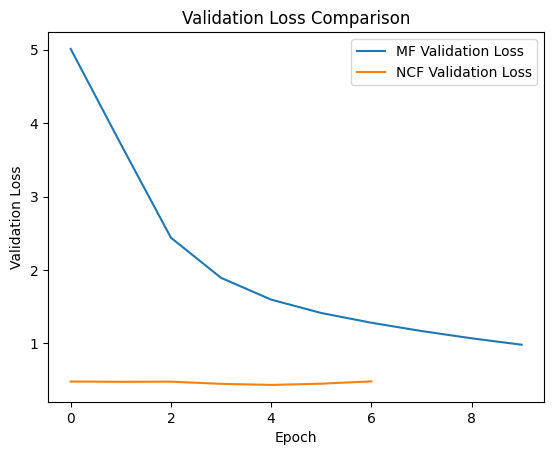

In [51]:
plt.plot(history_mf.history['val_loss'], label='MF Validation Loss')
plt.plot(history_ncf.history['val_loss'], label='NCF Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.show()

100%|██████████| 942/942 [01:47<00:00,  8.80it/s]


Model Comparison (k=10):
Model                          Recall@10  NDCG@10   
Matrix Factorization           0.3450     0.1693
Neural Collaborative Filtering 0.6518     0.3827


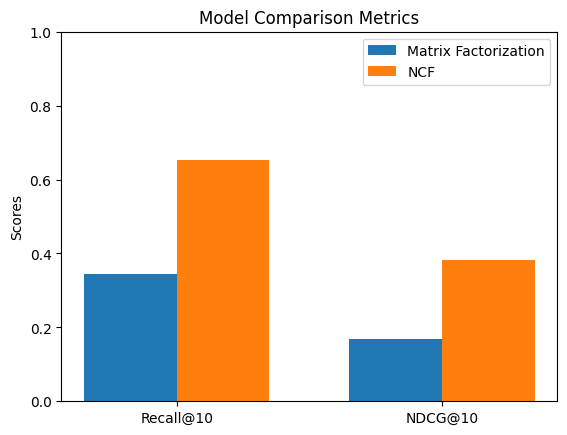

In [53]:
def get_metrics(model, test_data, k=10):
    hits, ndcgs = [], []
    for row in tqdm(test_data.itertuples(), total=len(test_data)):
        user = row.user
        pos_item = row.item
        neg_items = list(all_items - user_pos_items[user])
        neg_samples = random.sample(neg_items, 99)
        items_to_rank = neg_samples + [pos_item]

        users = [user] * len(items_to_rank)
        predictions = model.predict([np.array(users), np.array(items_to_rank)], verbose=0).flatten()

        item_score = list(zip(items_to_rank, predictions))
        item_score.sort(key=lambda x: x[1], reverse=True)
        ranked_items = [x[0] for x in item_score]

        hits.append(recall_at_k(ranked_items, {pos_item}, k))
        ndcgs.append(ndcg_at_k(ranked_items, {pos_item}, k))

    return np.mean(hits), np.mean(ndcgs)

# Evaluate Matrix Factorization Model
recall_mf, ndcg_mf = get_metrics(model_mf, test_df, k=10)

# Evaluate Neural Collaborative Filtering Model
recall_ncf, ndcg_ncf = get_metrics(model_ncf, test_df, k=10)


# Print side-by-side comparison
print("Model Comparison (k=10):")
print(f"{'Model':<30} {'Recall@10':<10} {'NDCG@10':<10}")
print(f"{'Matrix Factorization':<30} {recall_mf:.4f}     {ndcg_mf:.4f}")
print(f"{'Neural Collaborative Filtering':<30} {recall_ncf:.4f}     {ndcg_ncf:.4f}")



labels = ['Recall@10', 'NDCG@10']
mf_scores = [recall_mf, ndcg_mf]
ncf_scores = [recall_ncf, ndcg_ncf]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mf_scores, width, label='Matrix Factorization')
rects2 = ax.bar(x + width/2, ncf_scores, width, label='NCF')

ax.set_ylabel('Scores')
ax.set_title('Model Comparison Metrics')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.ylim(0, 1)
plt.show()

**Collaborative Filtering with Deep Neural Networks**

This assignment implements two deep learning models for collaborative filtering recommendation tasks using the MovieLens 100k dataset. The dataset is converted from explicit ratings into implicit feedback by treating ratings of 4 and above as positive user-item interactions. Negative samples are generated by randomly sampling items that a user has not interacted with, enabling the models to distinguish positive interactions from negatives.

Models:

Matrix Factorization (MF): A classical collaborative filtering technique that learns latent embeddings for users and items, combining them via dot product to estimate user-item interaction probability. This model serves as a baseline shallow embedding approach.

Neural Collaborative Filtering (NCF): An extension of MF that uses multi-layer perceptrons (MLP) to model complex non-linear interactions between user and item embeddings, aiming to improve recommendation accuracy by learning richer representations.

Evaluation:

The models are evaluated using ranking metrics commonly used in recommender systems research:

Recall@k: Measures the proportion of relevant items (positive interactions) found in the top-k recommendations for each user.

NDCG@k (Normalized Discounted Cumulative Gain): Takes into account the position of relevant items in the ranked list, giving higher scores to relevant items appearing higher in the list.

These metrics focus on ranking quality rather than rating prediction accuracy, aligning with typical collaborative filtering goals.


Results:

The results show that the Neural Collaborative Filtering (NCF) model significantly outperforms the Matrix Factorization (MF) model in both Recall@10 and NDCG@10 metrics. This indicates that NCF is better at accurately ranking relevant items higher in the recommendation list, demonstrating the advantage of deep learning approaches for collaborative filtering tasks.








